Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].


Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [2]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from analysis_lib import _get_swath, _load_tif_data
from analysis_lib import _get_colors, _gen_patches, _anl_agl
from analysis_lib import cluster_plotting2, cluster_plotting

In [35]:
from analysis_lib import _cluster_plotting

In [3]:
from sklearn.metrics import silhouette_score as sil

### KNN labeld data

In [4]:
datadir='/home/tkurihana/scratch-midway2/anl/sd_knn_2015_07'
filename='knn_label_spark_2.npy'

In [5]:
knn_labels = np.load(datadir+'/'+filename)

### Swath Image

In [12]:
gee_datadir = '/home/tkurihana/scratch-midway2/data/GEE/clouds_gee_2015_2016'
swath_filename = '2015-06-28_MOD09GA_background_removal_zero_inputated_image_with_cf_10perc_grid_size10-0000017664-0000070656.tif'
swath1 = _get_swath(gee_datadir, swath_filename)

 Shape  (9054, 9496, 7)


### Encoder 

In [10]:
model_dir='/home/tkurihana/clouds/output/m9-22_oceans/'

In [11]:
# encoder part
ENCODER_DEF=model_dir+'encoder.json'
ENCODER_WEIGHTS=model_dir+'encoder.h5'
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [13]:
patches = _gen_patches(swath1, normalization=True)
encs = encoder.predict( patches.reshape((-1,128,128,7)) )
encs_mean = encs.mean(axis=(1,2))

### Shapes

In [14]:
encs_mean.shape

(5180, 128)

In [15]:
knn_labels.shape

(70, 74)

In [16]:
labels_array = knn_labels.flatten()

### Silhoutte

In [23]:
sil(encs_mean, labels=labels_array, metric='euclidean')

-0.12847435

### Agglomerative

In [27]:
method = AgglomerativeClustering(n_clusters=10)
agl_patches_labels = method.fit_predict(encs_mean) #.reshape(patches.shape[:2])

In [28]:
agl_patches_labels

array([9, 9, 9, ..., 5, 0, 2])

In [29]:
sil(encs_mean, labels=agl_patches_labels, metric='euclidean')

0.54544824

### plot

In [30]:
colors = _get_colors(n=10)

In [31]:
SHAPE = 128, 128, 7

#### Bisecting Kmeans + KNN

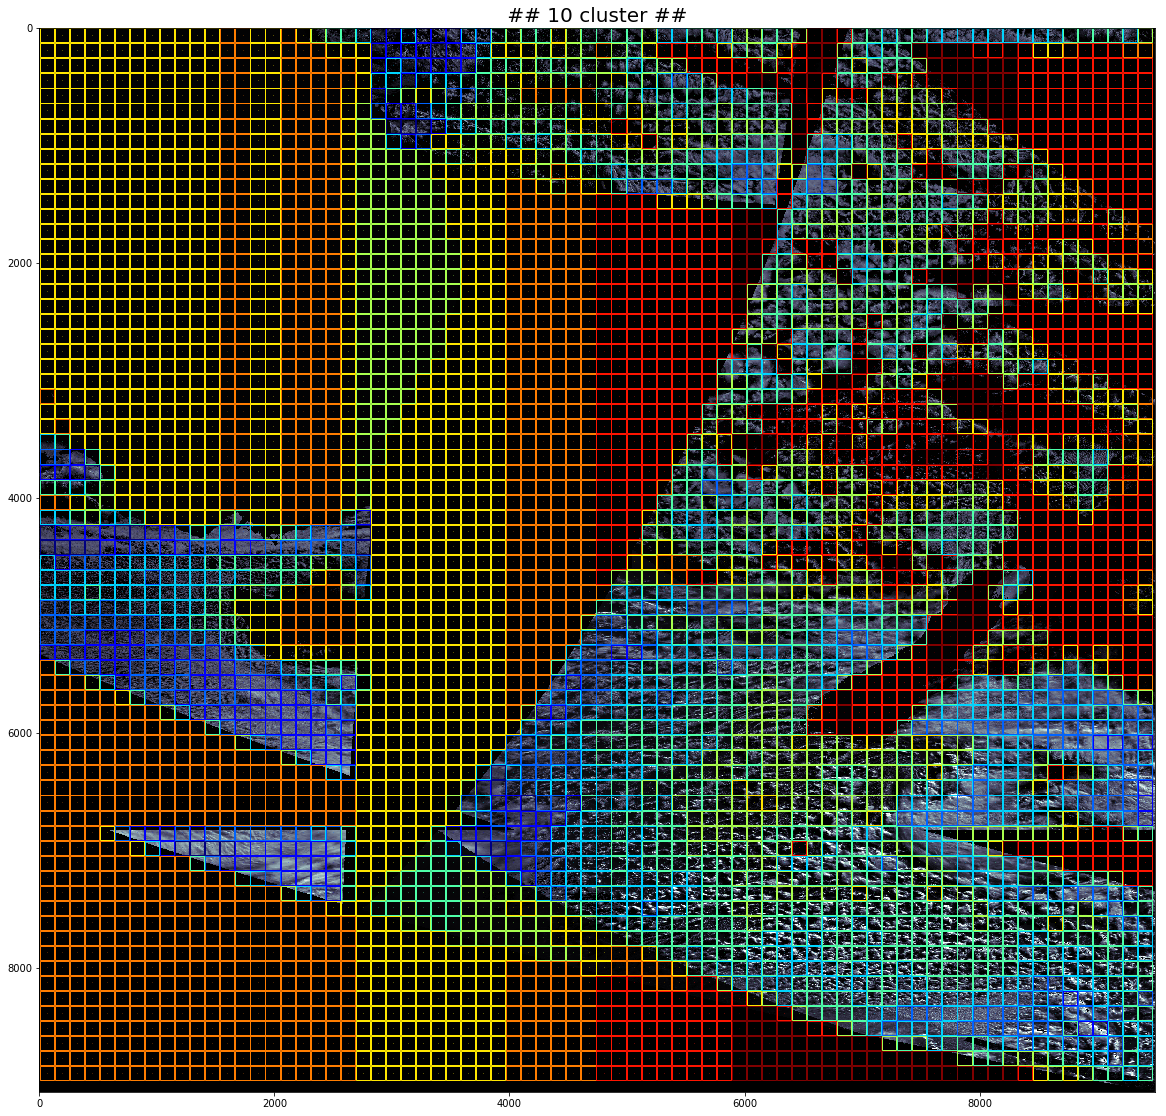

In [36]:
_cluster_plotting(swath1, patches, knn_labels, SHAPE, colors, ncluster=10)

### Agglomerative

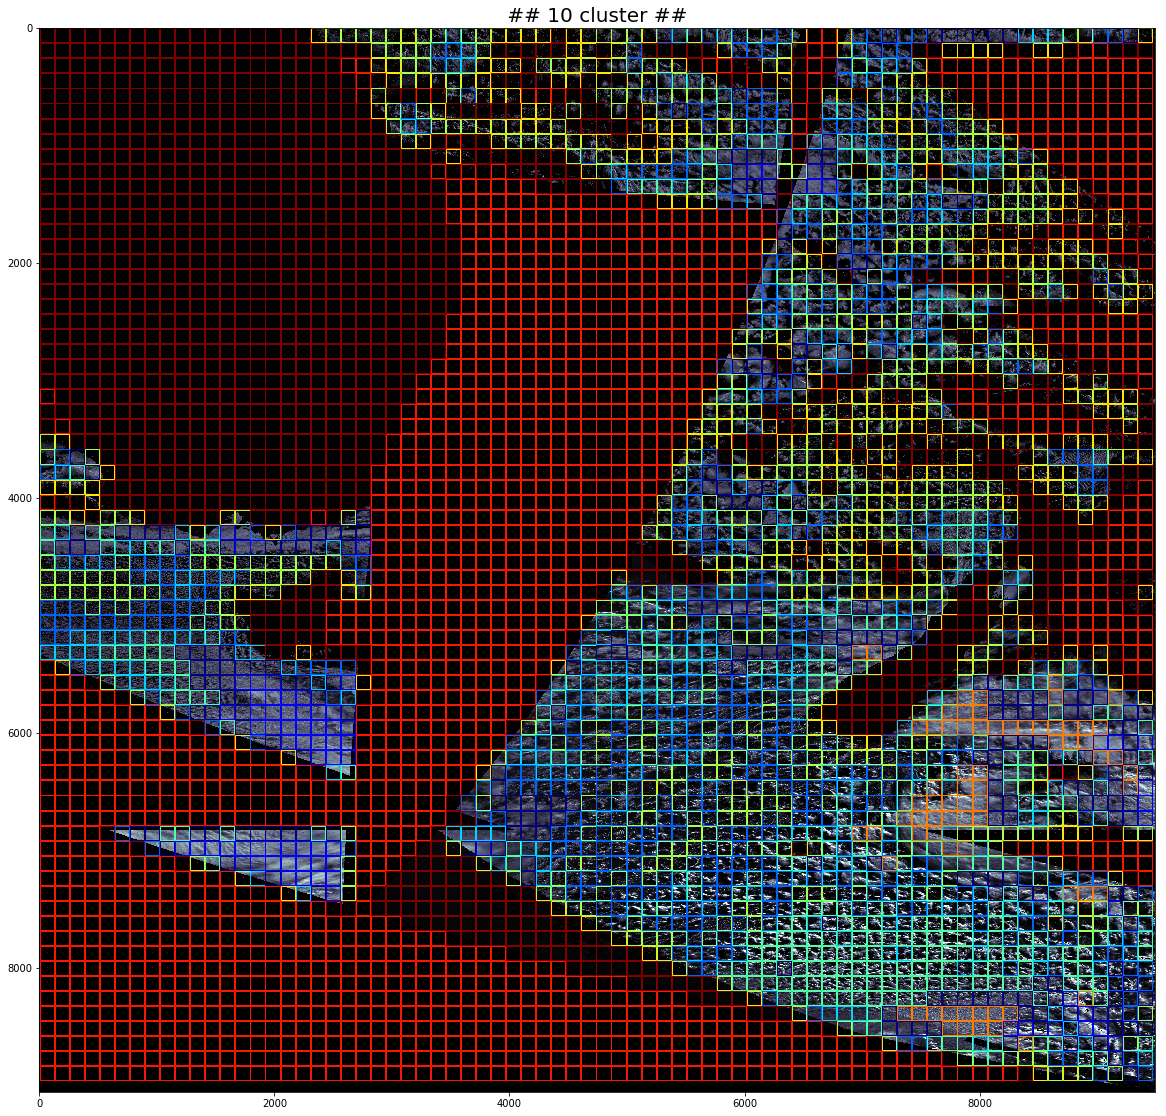

In [37]:
_cluster_plotting(swath1, patches, agl_patches_labels.reshape(patches.shape[:2])
                 , SHAPE, colors, ncluster=10)

### Sil with valid patches only (without backgrounds)

<BarContainer object of 10 artists>

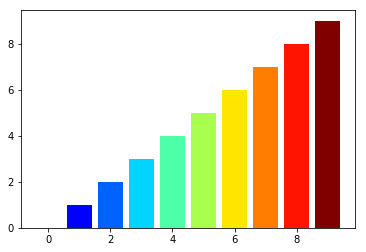

In [39]:
plt.bar(np.arange(10), [ i for i in range(10)], color=colors)

===> erase 6 , 7, 8, 9 

##### KNN

In [40]:
idxs = []
for i in range(6):
    idxs.extend(np.where(knn_labels == i)[0] )

In [45]:
new_encs_mean = encs_mean[idxs]
new_knn_labels = labels_array[idxs]

In [46]:
sil(new_encs_mean, labels=new_knn_labels, metric='euclidean')

-0.11748452

##### Agglo

In [53]:
idxs = []
for i in range(8):
    idxs.extend(np.where(agl_patches_labels == i)[0] )

In [54]:
new_encs_mean = encs_mean[idxs]
new_agl_labels = agl_patches_labels[idxs]

In [55]:
sil(new_encs_mean, labels=new_agl_labels, metric='euclidean')

0.2734445

### Another Swath 

Swath in which I used for base case. Apply agglomerative and mesure sil score here.  

In [56]:
gee_datadir = '/home/tkurihana/scratch-midway2/data/GEE'
swath_filename = '2017-01-01_MOD09GA_mixed-cell.tif'
swath1 = _get_swath(gee_datadir, swath_filename)

 Shape  (2219, 4991, 7)


In [57]:
patches = _gen_patches(swath1, normalization=True)
encs = encoder.predict( patches.reshape((-1,128,128,7)) )
encs_mean = encs.mean(axis=(1,2))

In [58]:
method = AgglomerativeClustering(n_clusters=10)
agl_patches_labels = method.fit_predict(encs_mean) #.reshape(patches.shape[:2])

In [59]:
sil(encs_mean, labels=agl_patches_labels, metric='euclidean')

0.33347505

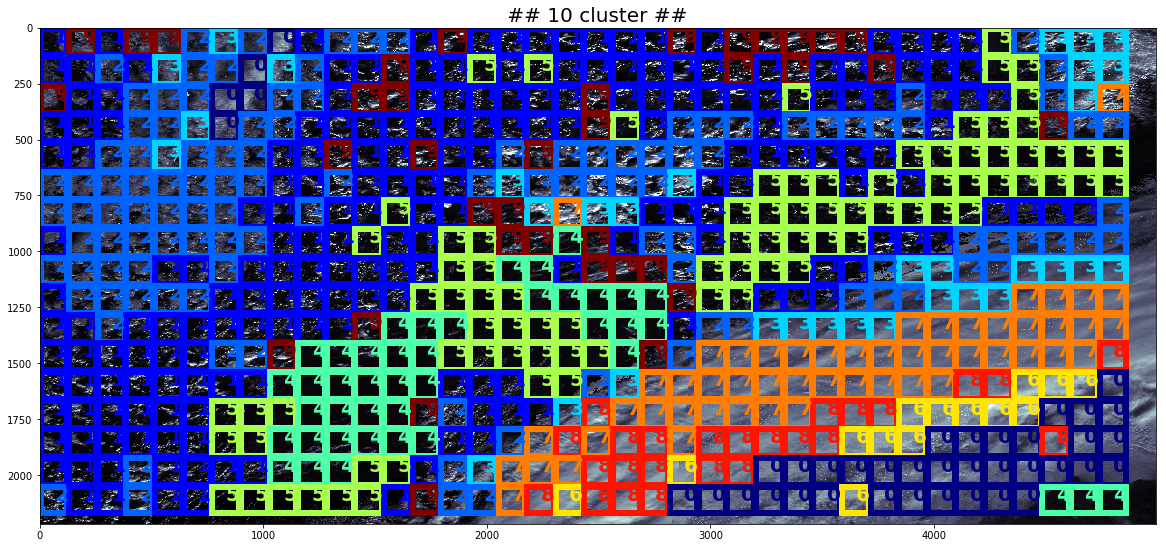

In [60]:
cluster_plotting(swath1, patches, agl_patches_labels.reshape(patches.shape[:2])
                 , SHAPE, colors, ncluster=10)

In [61]:
idxs = []
for i in [0,1,2,3,6,7,8,9]:
    idxs.extend(np.where(agl_patches_labels == i)[0] )

In [62]:
new_encs_mean = encs_mean[idxs]
new_agl_labels = agl_patches_labels[idxs]

In [64]:
sil(new_encs_mean, labels=new_agl_labels, metric='euclidean')

0.32720414

### Summary

Even though elbow method showed one index to decide measure, sil showes another perspective.